In [72]:
import sys
sys.path.insert(1, '../../libs')
from utils import get_data, temporal_train_test_split


import sys
sys.path.insert(1, '../../libs')
from utils import temporal_train_test_split, evaluate_bert
from autorship import AuthorClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [2]:
data = pd.read_csv("../../data/authors_bert.csv").drop(["Unnamed: 0", "comment"], axis=1)
data.head()

,username,created_utc,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_759,emb_760,emb_761,emb_762,emb_763,emb_764,emb_765,emb_766,emb_767,emb_768
0,Manada_2,2022-03-09 14:17:46+00:00,0.230650,0.022300,0.009343,-0.022771,0.290211,0.020917,-0.009539,0.097825,...,-0.020931,0.354142,-0.283546,-0.299946,0.193261,-0.084011,-0.091721,-0.417421,-0.220645,0.110566
1,BluePirate89,2022-03-31 16:00:06+00:00,0.049211,-0.134950,0.683201,-0.156496,0.245604,0.179675,0.007007,-0.312811,...,-0.106805,0.079122,-0.155585,-0.310752,0.332965,-0.026474,0.115311,-0.072641,0.151321,-0.403907
2,9-Cortes,2021-11-29 02:08:23+00:00,-0.033197,-0.069910,-0.029060,0.122222,0.745492,0.049575,0.162378,0.105202,...,0.009278,-0.165076,0.114492,0.008429,0.521520,-0.252321,0.156320,0.137112,0.095263,-0.285079
3,Supermunch2000,2021-12-21 12:01:05+00:00,-0.111692,0.001248,0.258670,-0.117452,0.261348,0.427504,-0.430138,-0.255422,...,-0.007786,0.048536,-0.392350,-0.171661,0.321356,-0.262561,0.397757,-0.058622,0.138947,-0.739329
4,TheGza1,2021-08-10 12:49:03+00:00,-0.218113,-0.152065,0.283837,-0.108286,0.430704,0.162810,0.000672,-0.046517,...,0.116052,-0.038508,-0.345945,-0.136400,0.242163,-0.418695,-0.129335,0.173007,-0.047265,-0.160961


In [3]:
data.groupby("username").count()["created_utc"]

username
9-Cortes            902
AgnaldoTeExplode    914
BeatoSalut          886
BluePirate89        980
CariocaSatanico     724
Manada_2            913
MaxVonHabsburg      945
MidnightRider00     883
Miteiro             940
Supermunch2000      950
TheGza1             895
logatwork           933
piperman_           858
um--no              893
xanax101010         937
Name: created_utc, dtype: int64

In [4]:
estimators = [
        ('svm', LinearSVC(random_state=42, max_iter=10000)),
        ('lr_l1', LogisticRegression(random_state=42, penalty="l1", solver="liblinear"),
        ('rf'), RandomForestClassifier(random_state=42))]
stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=42, penalty="l2", solver="liblinear"))

clfs = [MultinomialNB(),
        LogisticRegression(random_state=42, penalty="l1", solver="liblinear"),
        LogisticRegression(random_state=42, penalty="l2", solver="liblinear"),
        LinearSVC(random_state=42, max_iter=10000),
        SVC(random_state=42),
        DecisionTreeClassifier(random_state=42),
        RandomForestClassifier(random_state=42),
        AdaBoostClassifier(random_state=42),
        GradientBoostingClassifier(random_state=42),
        stacking
        ]

In [5]:
def process(clf):
    clf_str = clf.__str__()
    print(f"Running ===> {clf_str}")
    evaluation = list()
    clf_list = list()
    usernames = list(np.unique(data["username"]))

    for i in range(len(usernames)):
        author1 = usernames.pop()

        for author2 in usernames:
            X_train, X_test, y_train, y_test = temporal_train_test_split(   
                data, author1, author2)

            scaler = MinMaxScaler().fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)

            author_clf = clf
            author_clf.fit(X_train, y_train)
            y_pred = author_clf.predict(X_test)
            try:
                predict_proba = author_clf.predict_proba(X_test)[:,1]
            except:
                predict_proba = author_clf.decision_function(X_test)
            evaluation.append(evaluate_bert(y_test, y_pred, predict_proba, author1, author2))
            clf_list.append(clf_str)
            metrics = pd.DataFrame(evaluation)[["f1_macro", "recall_macro", "precision_macro", "accuracy", "auc_score"]].mean()
    print(f"Finish <=== {clf_str}")
    return (clf_str, metrics, evaluation, clf_list)

results = Parallel(n_jobs=-1)(delayed(process)(clf) for clf in clfs)

Running ===> MultinomialNB()
Running ===> LogisticRegression(penalty='l1', random_state=42, solver='liblinear')
Running ===> SVC(random_state=42)
Running ===> LogisticRegression(random_state=42, solver='liblinear')
Running ===> DecisionTreeClassifier(random_state=42)
Running ===> AdaBoostClassifier(random_state=42)
Running ===> RandomForestClassifier(random_state=42)
Running ===> LinearSVC(max_iter=10000, random_state=42)
Finish <=== MultinomialNB()
Running ===> GradientBoostingClassifier(random_state=42)
Finish <=== LogisticRegression(random_state=42, solver='liblinear')
Running ===> StackingClassifier(estimators=[('svm',
                                LinearSVC(max_iter=10000, random_state=42)),
                               ('lr_l1',
                                LogisticRegression(penalty='l1',
                                                   random_state=42,
                                                   solver='liblinear'),
                                'rf',
        

In [59]:
scores = [results[i][2] for i in range(10)]
clfs_list = [results[i][3] for i in range(10)]

In [67]:
import itertools
clfs_list = list(itertools.chain(*clfs_list))
scores = list(itertools.chain(*scores))

In [68]:
metrics_full = pd.concat([pd.DataFrame(scores), pd.DataFrame(clfs_list, columns=["clf"])], axis=1)
metrics_full

,author1,precision_author1,recall_author1,f1_score_author1,author2,precision_author2,recall_author2,f1_score_author2,precision_weighted,precision_micro,precision_macro,recall_weighted,recall_micro,recall_macro,f1_weighted,f1_micro,f1_macro,auc_score,accuracy,clf
0,xanax101010,0.9302,0.5106,0.6593,9-Cortes,0.6536,0.9602,0.7778,0.7946,0.7310,0.7919,0.7310,0.7310,0.7354,0.7174,0.7310,0.7186,0.9488,0.7310,MultinomialNB()
1,xanax101010,0.9151,0.4128,0.5689,AgnaldoTeExplode,0.6145,0.9607,0.7496,0.7668,0.6832,0.7648,0.6832,0.6832,0.6867,0.6581,0.6832,0.6592,0.9099,0.6832,MultinomialNB()
2,xanax101010,0.5758,0.4043,0.4750,BeatoSalut,0.5205,0.6847,0.5914,0.5489,0.5405,0.5482,0.5405,0.5405,0.5445,0.5316,0.5405,0.5332,0.7040,0.5405,MultinomialNB()
3,xanax101010,0.6269,0.6936,0.6586,BluePirate89,0.6727,0.6041,0.6366,0.6503,0.6479,0.6498,0.6479,0.6479,0.6488,0.6473,0.6479,0.6476,0.6730,0.6479,MultinomialNB()
4,xanax101010,0.9016,0.4681,0.6162,CariocaSatanico,0.5748,0.9337,0.7116,0.7594,0.6707,0.7382,0.6707,0.6707,0.7009,0.6577,0.6707,0.6639,0.8992,0.6707,MultinomialNB()
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,BluePirate89,0.9102,0.9102,0.9102,AgnaldoTeExplode,0.9039,0.9039,0.9039,0.9072,0.9072,0.9071,0.9072,0.9072,0.9071,0.9072,0.9072,0.9071,0.9690,0.9072,"StackingClassifier(estimators=[('svm',\n ..."
1046,BluePirate89,0.7868,0.8286,0.8072,BeatoSalut,0.7990,0.7523,0.7749,0.7926,0.7923,0.7929,0.7923,0.7923,0.7904,0.7918,0.7923,0.7910,0.8477,0.7923,"StackingClassifier(estimators=[('svm',\n ..."
1047,BeatoSalut,0.8869,0.8829,0.8849,9-Cortes,0.8855,0.8894,0.8874,0.8862,0.8862,0.8862,0.8862,0.8862,0.8861,0.8862,0.8862,0.8861,0.9606,0.8862,"StackingClassifier(estimators=[('svm',\n ..."
1048,BeatoSalut,0.8611,0.8378,0.8493,AgnaldoTeExplode,0.8468,0.8690,0.8578,0.8538,0.8537,0.8540,0.8537,0.8537,0.8534,0.8536,0.8537,0.8535,0.9187,0.8537,"StackingClassifier(estimators=[('svm',\n ..."


In [69]:
metrics_full.to_csv("../../results/bert_results_full.csv")

Text(0, 0.5, 'Acurácia')

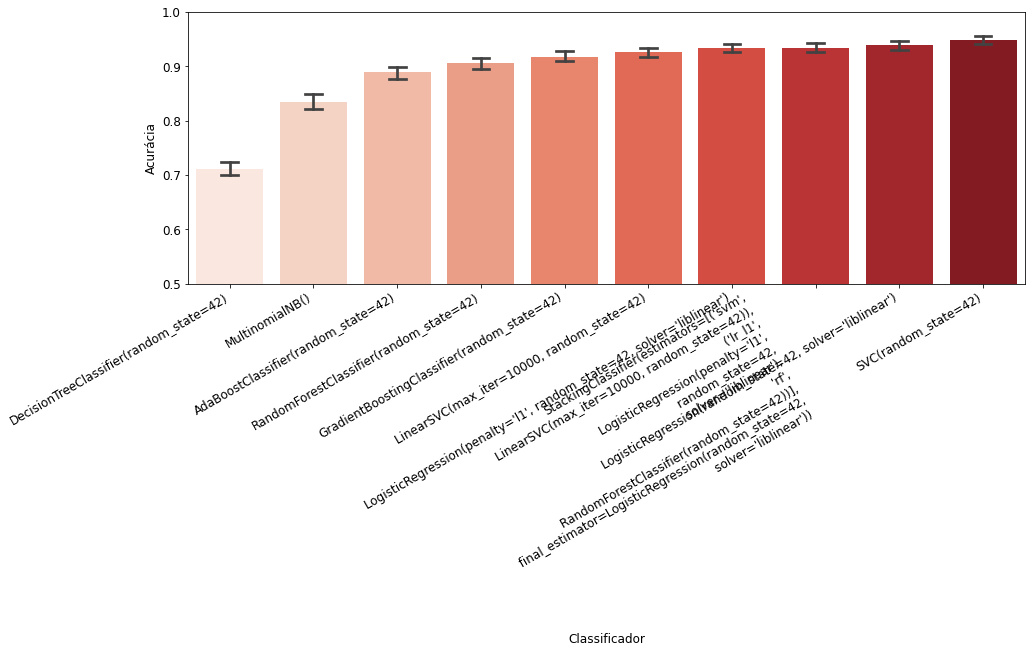

In [76]:
font = {'size': 12}

matplotlib.rc('font', **font)

plt.figure(figsize=(15,5))
plt.ylim(0.5, 1)
plt.xticks(rotation=30, ha='right')
sns.barplot(x='clf', y='auc_score', data=metrics_full, estimator=np.mean, ci=95, capsize=.2,palette="Reds", order=metrics_full.groupby("clf").mean()["accuracy"].sort_values().reset_index()["clf"])
plt.xlabel('Classificador')
plt.ylabel('Acurácia')

In [8]:
metrics_df = pd.DataFrame([results[i][1] for i in range(len(results))])
metrics_df["classifier"] = [results[i][0] for i in range(len(results))]
metrics_df

,f1_macro,recall_macro,precision_macro,accuracy,auc_score,classifier
0,0.706826,0.716972,0.739695,0.714608,0.834214,MultinomialNB()
1,0.870744,0.870910,0.871315,0.871059,0.933232,"LogisticRegression(penalty='l1', random_state=..."
2,0.876614,0.876746,0.877249,0.876939,0.939154,"LogisticRegression(random_state=42, solver='li..."
3,0.862117,0.862388,0.862555,0.862384,0.925298,"LinearSVC(max_iter=10000, random_state=42)"
4,0.884814,0.884771,0.886411,0.885252,0.948604,SVC(random_state=42)
5,0.711033,0.711479,0.711810,0.711690,0.711440,DecisionTreeClassifier(random_state=42)
6,0.828343,0.828685,0.831932,0.829323,0.905814,RandomForestClassifier(random_state=42)
7,0.814322,0.814671,0.814790,0.814701,0.888587,AdaBoostClassifier(random_state=42)
8,0.844811,0.845000,0.846225,0.845349,0.917809,GradientBoostingClassifier(random_state=42)
9,0.872861,0.872970,0.873428,0.873187,0.934193,"StackingClassifier(estimators=[('svm',\n ..."


In [9]:
metrics_df.to_csv("../../results/bert_results.csv")